# PACKAGES

The following packages were needed to implement RTEA. The "PyGMO" package shown below as "pygmo" is a scientific library providing a large number of optimisation problems and algorithms. We used the package in order to use the following implementations:

- **fast_non_dominated_sorting:** An implementation of the fast non dominated sorting algorithm.
- **select_best_N_mo:** Sorts a population with respect to the following strict ordering:

            i)f1≺f2 if the non domination ranks are such that i1 $<$ i2.

            ii) In case i1=i2, then f1≺f2 if the crowding distances are such that  d1$>$d2.

For more information visit: https://esa.github.io/pagmo2/index.html

In [1]:
import pygmo as pg
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv
import pandas as pd
import numpy as np
import random
import os
import operator
from pygmo import hypervolume

# SIMULATION MODEL

Simulation Model translated from Matlab to Python

In [2]:
#   ****************************************
#   ***   Code written by Jessica Wu     ***
#   ***        lw353@cornell.edu         ***
#   ****************************************

# Translated by Michael Luya from Matlab to Python on 3/4/2018.
# Updated by Aliya Jangabylova on 3/4/2018.

# Last updated 8/1/2012

# RETURNS: average total cost of production, transportation, outsourcing,
# and inventory holdings

import numpy as np
import randomstate as rnd
import random as rd

def SupplyChain(x, runlength = 2, seed = random.randint(1,10000)):
    
    x = np.reshape(x,(5,3))
# x is a 5x3 matrix, and it specifies the policy used to determine production
# runlength is the number of years to run the simulation
# seed is the index of the substreams to use (integer >= 1)
# other is not used

    if (np.sum(np.sum(k < 0 for k in x))>0 or (runlength <= 0) or
        (runlength != round(runlength)) or (seed <= 0) or (round(seed) != seed)):
        print('x should be >= 0, runlength should be positive integer, seed must be a positive integer\n')
        
    else:
        T = 52 # number of periods
        var = .3 # coeff of the variation of demand
        facilities = 3 # number of production plants
        salesRegions = 8
        products = 5 # number of products
        C = [.3, .5, .4, .2, .4] # production cost in dollars
        t = .02 # transportation cost 
        h = [.4, .3, .6, .2, .3] # inventory cost
        # e = [.8 .7 1.2 .9 1.1] # outsourcing cost
        e = [0.01, 0.01, 0.01, 0.01, 0.01] # outsourcing cost
        distance = np.array([[32, 21, 19, 31, 22, 35, 18, 33],
                            [25, 36, 30, 24, 16, 14, 31, 19],
                            [18, 12, 27, 11, 33, 28, 23, 22]]) # distance in miles from facility to sales region
        maximum = 70 # maximum order size
        minimum = 1 # minimum order size
        
    ## Generate data ##############################################################################################
    
    ExpectedStream = rnd.prng.mrg32k3a.RandomState(seed)
    DemandStream = ExpectedStream # MODIFIED JUAN
    
    U = np.round(ExpectedStream.normal(6,2,size = [5,8])); # mean demand from each region for each product
    U = U.astype(int)
    
    demands = np.zeros((products, salesRegions, T*runlength))
    
    for i in range(0,T*runlength): 
        
        demands[:,:,i] = np.round(DemandStream.normal(U,np.sqrt(var)))
        
        #The while loop runs until the accumulated demand is between minimun and maximun (JUAN)
        while np.sum(np.sum(k < minimum for k in demands[:,:,i])) or np.sum(np.sum(k > maximum for k in demands[:,:,i])):
            
            demands[:,:,i] = np.round(DemandStream.normal(U,np.sqrt(var)))

    ## Main Simulation ############################################################################################
    
    P = np.zeros((products,facilities, T*runlength)) # amount produced
    S = np.zeros((products,facilities, T*runlength)) # amount transported
    O = np.zeros((products,salesRegions, T*runlength)) # amount outsourced
    I = np.zeros((products,facilities, T*runlength+1)) # inventory levels
    serviceLevel = 0
    
    targetInventory = np.zeros((products, facilities))
  
    # COMPUTES THE INVENTORY IN EACH FACILITY TO SUPPLY THE THREE NEAREST SALES REGIONS.
    # IF X=1's the inventory is equal to the demand. COMMENT JUAN
    for i in range(0,facilities):       
        base = 0    
        for j in range(0,3):     
            low = 1000
            index = 0         
            for k in range(0,salesRegions): # finding the three closest sales regions           
                dki = distance[i,k] #COMPUTING DISTANCE BETWEEN FACILITIES AND SALES REGIONS. CHANGED BY JUAN
                if dki < low and dki >base:            
                    low = dki
                    index = k         
            base = low
            targetInventory[:,i] = targetInventory[:,i] + U[:,index] # targetInv at facility i and mean demand at sales region_index
            # total targetInventory from all facilities
#     print('Mean Demand')
#     print(U)
    
    targetInventory = np.multiply(targetInventory, x) #JBR
  
    for i in range(0,T*runlength):
#         print('Inventory lvl:' ,I[:,:,i])
#         print('Demand product x SalesRegion:' ,demands[:,:,i])
#         print('targetInventory: ',targetInventory)
#         print('Amount Produced(P) products x facilities: ',P[:,:,i])
#         print('Amount Transported(S) products x facilities: ',S[:,:,i])
#         print('Amount Outsourced(O) products x salesregions: ',O[:,:,i])
        if (I[:,:,i] < targetInventory).all(): #MODIFIED JUAN. Now produces everytime there's a shortage in any product on inventary
            P[:,:,i] = targetInventory - I[:,:,i] # producing to the target inventory level
            I[:,:,i] = I[:,:,i] + P[:,:,i]  # total amount of target inventory level

        #FINDING CLOSEST FACILITY. SAME STRUCTURE AS BEFORE.COMMENT BY JUAN. 
        for j in range(0,salesRegions):
            base = 0
            for m in range(0,3):   
                low = 1000
                index = 0
                for k in range(0,facilities): # find the closest facilities 
                    dkj = distance[k,j] # CHANGED BY JUAN
                    if dkj < low and dkj > base:  
                        low = dkj
                        index = k
                    
                for k in range(0,products): # facility fills the orders
                    
                    if demands[k,j,i] > I[k,index,i] and demands[k,j,i] > 0:
                        
                        demands[k,j,i] = demands[k,j,i] - I[k,index,i]  # total demand - inv.levels
                        S[k,index,i] = I[k,index,i]  # amount transported = inventory levels
                        I[k,index,i] = 0
                        I[k,index,i+1] = I[k,index,i] #MODIFIED JUAN
                        
                    elif demands[k,j,i] <= I[k,index,i] and demands[k,j,i] > 0:
                        
                        S[k,index,i] = demands[k,j,i] # transport all the demands
                        demands[k,j,i] = 0  # zero demands left
                        I[k,index,i] = I[k,index,i] - S[k,index,i]  # inv.level at facility..- amount transported
                        #if i < T*runlength-1:   # otherwise i+1 is bigger than the size T*runlength #MODIFIED JUAN
                        I[k,index,i+1] = I[k,index,i]
                                        
                    base = low # to find the next closest facility


            for k in range(0,products):
                
                if demands[k,j,i] > 0: # remaining order is filled by outsourcing
                    
                    O[k,j,i] = demands[k,j,i]
                    demands[k,j,i] = 0
                    serviceLevel += 1
                    
            

# Single objective 
    costs = np.sum(C*np.sum(np.sum(P,axis = 2),axis = 1)) + np.sum(t*np.sum(np.sum(S,axis = 2),axis = 1)) + np.sum(e*np.sum(np.sum(O,axis = 2),axis = 1))+ np.sum(h*np.sum(np.sum(I,axis = 2),axis = 1))
                
    
    ## End of Simulation; Generate results ######################################################################
    
    fn =  costs/runlength/np.sum(np.sum(np.sum(P,axis = 2),axis = 1)) # cost function
    fn2 = np.float((products*salesRegions*runlength*T - serviceLevel))/np.float(products*salesRegions*T*runlength) #customer service level

    return [fn, -fn2]

/usr/local/lib/python2.7/dist-packages/randomstate/__init__.py:66: RandomStateDeprecationWarning: 
**End-of-life notification**

This library was designed to bring alternative generators to the NumPy 
infrastructure. It as been successful in advancing the conversation 
for a future implementation of a new random number API in NumPy which 
will allow new algorithms and/or generators. The next step
in this process is to separate the basic (or core RNG) from the 
functions that transform random bits into useful random numbers.
This has been implemented in a successor project  **randomgen** 
available on GitHub

https://github.com/bashtage/randomgen

or PyPi

https://pypi.org/project/randomstate/.

randomgen has a slightly different API, so please see the randomgen documentation

https://bashtage.github.io/randomgen.

  warnings.warn(DEPRECATION_MESSAGE, RandomStateDeprecationWarning)


# ALGORITHM SETTING AND SOLUTION

class **RTEA** is the optimisation algorithm used for Supply Chain. This recives just the initial population size as parameter.

In [12]:
class RTEA:

    def evolve(self, pop, evaluations=4000, k_iterations=1):

        g = evaluations    #number of evaluations made
        pop_size = pop     #Initial population size
        p_cross = 0.95     # Probability to a apply crossover to a generated individual 
        lb = 0.6           #Lower Bound of each element of the input variable
        ub = 1.1           #Upper Bound of each element of the input variable
        cont_dim = 15      #Dimension of the input variable. This will be resized inside Supply Chain code as a 5x3 matrix   
        search_proportion = 0.95   #Percentage of iterations that pass before turning off main part of the algorithm and just apply the Rolling Tide loop (SEE JUST --SECOND BIG LOOP--)
        t=pop              #Counts the number of evaluations made in the supply chain code.
        
        #%%%%%%%%%%%%%%%%%% Just applicable for stats shown in the report for hypervolume computation
        rf = True
        HyperC_list = []
        ref_point = [ 1.0 , -0.1] # reference point set for hypervolume computation.
        #%%%%%%%%%%%%%%%%%%%
        
        INDV_F ={}        #Dictionary with a numerical tag for each individual and all the Objective function values obtained from re-evaluation.
        POPU_X = {}      #Dictionary with a numerical tag for each individual and the associated decision variable.
        POPU_F = {}      #Dictionary with a numerical tag for each individual and the associated ESTIMATION of Objective function. For each individual, this is the mean of INDV_F
        samples_A = {}   #Number of re-evaluations for each non-dominated individual.
        samples_pop = {} #Number of re-evaluations for all individuals. Dominated and non-dominated.
        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        #INITIALIZING RANDOM POPULATION
        
        for j in range(pop_size):
            POPU_X[j] = [random.uniform(lb,ub) for i in range(cont_dim)]
            POPU_F[j] = list(SupplyChain(list(POPU_X[j]),2,random.randint(1,1000)))
            INDV_F[j] = [POPU_F[j]]
       
        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        # The algorithm now starts manipulating the population
        
        #LEGEND 
        
        #A:Decision variable "x" of Non-Dominated individuals
        #F: Value of Decision variable "SupplyChain(x)" of non-Dominated individuals.
        #X: Decision variable "x" of Dominated individuals.
        #Y:Value of Decision variable "SupplyChain(x)" of Dominated individuals.
        
        A,F,X,Y = get_A_F(POPU_X,POPU_F) #Get non-dominated individuals decision vectors and value from initial population 
       
        
        for i in A.keys():    #This loops set the counter to 1 for each individual
            samples_A[i] = 1
            samples_pop[i] = 1
        M = len(POPU_X)-1 #M is just an auxiliary variable inside the code
        
        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        #LVL1. Checks if the condition if the 4000 iterations passed in order to stop the optimisation algorithm.
        while t<=g:
            print(t,' evaluations made in Supply Chain code')   #Sanity check
            
            #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
            #This part only calculates the Hypervolume computation for each iteration. In case where this is not necessary, it can be set as comment.
            F1 = []
            F2 = []
            
            Obj_val = F.values()
            
            F1 = [ Obj_val[j][0] for j in range(len(Obj_val))]
            F2 = [ Obj_val[j][1] for j in range(len(Obj_val))]
            
            F_HV = [[ F1[i],F2[i]] for i in range(len(F1))]            
            hv = hypervolume(F_HV)
            
            while (rf):
                rf = False
            HVval = hv.compute(ref_point)
            #print('hv',hv.compute(ref_point))
            HyperC_list.append(HVval)
            #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
            
            
            #FIRST LOOP
            #The main objective of this loop is generate new individuals using a simple crossover and mutation.
            #After the new individual is created the sets A,F and X,Y are updated.
            if t< search_proportion*g: #In the case of 4000 total evaluations, the algorithm will spend 3800 evaluations creating new individuals
  
                aux_F = F.values()  #Auxiliary list F
                aux_A = A.values()  #Auxiliary list A
        
                #SELECTION OF PARENTS AND CROSSOVER
                if len(aux_F) > 1:              
                    u_i,v_i = pg.select_best_N_mo(aux_F,2) #USE CROWDING DISTANCE along with ranking to select best two individuals.
                    u , v = aux_A[u_i],aux_A[v_i]

                    #crossover operation, generates 1 offspring
                    if random.uniform(0,1) < p_cross:
                        father, mother = u,v
                        index1 = random.randint(1, len(father) - 2)
                        index2 = random.randint(1, len(father) - 2)
                        if (index1 > index2):
                              index1, index2 = index2, index1
                        child = father[:index1] + mother[index1:index2] + father[index2:]
                        x = child
                    else:
                        x = u
                else:
                    x = A.values()[0]
                    
                #MUTATION, mutates the offspring varying one element of string with a uniform random distribution.
                index = random.randint(0, len(x) - 1)
                vary = random.uniform(lb, ub)
                mutated = list(x)
                mutated[index] = vary
                M+=1
          
                POPU_X[M] = mutated
                POPU_F[M] = list(SupplyChain(mutated,2,random.randint(1,1000)))

                INDV_F[M] = []
                INDV_F[M].append(POPU_F[M])
                
                #UPDATES A,F, X, Y, samples_A, samples_pop with new individual
                A,F,X,Y = get_A_F(POPU_X,POPU_F)
                samples_A,samples_pop = update_A(samples_pop,A)
                t+=1       
                     
            samples_A,samples_pop = update_A(samples_pop,A)
            
            #SECOND LOOP. Re-evaluation or Rolling Tide part of the algorithm.
            #if k_iterations is set to 1, the algorithm will re-evaluate just once for each iteration.
            for k in range(k_iterations):
                print(t,' evaluations made in Supply Chain code')   #Sanity check
                #finding element of A with smallest sample size
                x_pp = min(samples_A, key=samples_A.get)

                #evaluation of function
                DX = A[x_pp]
                y_pp = list(SupplyChain(list(DX),2,random.randint(1,1000)))
                
                #updating mean est(F)
                samples_A[x_pp] +=1
                samples_pop[x_pp] +=1   
                INDV_F[x_pp].append(y_pp)               
                F0 = np.mean(np.matrix(INDV_F[x_pp])[:,0]) 
                F1 = np.mean(np.matrix(INDV_F[x_pp])[:,1])
                F_est = [F0,F1]
                POPU_F[x_pp] = F_est

                #+1 to the budget
                t+=1

                #Update A, F, X, Y
                A,F,X,Y = get_A_F(POPU_X,POPU_F)
                samples_A,samples_pop = update_A(samples_pop,A)
        print('FINISHED.')
        return A,F,t,INDV_F,samples_A, HyperC_list,ref_point


In [38]:
#get_A_F updates the sets A, F, X, Y 
def get_A_F(pop_X,pop_F):
    
    index_pareto_front =pg.fast_non_dominated_sorting(pop_F.values())[0][0]
    X = {}
    Y = {}
    A = {}
    F = {}
    #ELEMENTS PARETO FRONT
    for i in list(index_pareto_front):
        A[int(i)] = pop_X[int(i)]
        F[int(i)] = pop_F[int(i)]
    
    #ELEMENTS NON PARETO FRONT
    a = np.array([])
    for i in list(pg.fast_non_dominated_sorting(pop_F.values())[0][1:-1]):
        
        a = np.concatenate((a,i))
    for i in list(a):
        X[int(i)] = pop_X[int(i)]
        Y[int(i)] = pop_F[int(i)]

    return A,F,X,Y

#update_A updates the samples_A and samples_pop 
def update_A(sample_pop,A_new):

    list_dif = A_new.keys()
    S = {}
    for i in list_dif:
        if i in sample_pop:
            S[i] = sample_pop[i]
        else:
            S[i] = 1
            sample_pop[i] = 1
    return S,sample_pop     

In [15]:
#INPUT
#evl is the number of evaluations in the supply chain code
#pop_size is the initial random population size
#k is the number of re-evaluations for each iteration of the algorithm

#OUTPUT
#A: decision vector for non-dominated individuals.
#F: estimated value of the decision vector for non-dominated individuals.
#t number of evaluations made inside the algorithm
#samples_A: number of evaluations for each instance.
#INDV_F: value of each evaluation made for each instance.
#HV_curve: hypervolume metric taken inside the algorithm.
#ref_point: reference point taken for the hypervolume metric

evl =4000
pop_size =40
k=1

alg = RTEA()
A,F,t,INDV_F,samples_A, HV_curve,ref_point  = alg.evolve(pop_size,evaluations=evl,k_iterations=k)

(40, ' evaluations made in Supply Chain code')
(41, ' evaluations made in Supply Chain code')
(42, ' evaluations made in Supply Chain code')
(43, ' evaluations made in Supply Chain code')
(44, ' evaluations made in Supply Chain code')
(45, ' evaluations made in Supply Chain code')
(46, ' evaluations made in Supply Chain code')
(47, ' evaluations made in Supply Chain code')
(48, ' evaluations made in Supply Chain code')
(49, ' evaluations made in Supply Chain code')
(50, ' evaluations made in Supply Chain code')
(51, ' evaluations made in Supply Chain code')
(52, ' evaluations made in Supply Chain code')
(53, ' evaluations made in Supply Chain code')
(54, ' evaluations made in Supply Chain code')
(55, ' evaluations made in Supply Chain code')
(56, ' evaluations made in Supply Chain code')
(57, ' evaluations made in Supply Chain code')
(58, ' evaluations made in Supply Chain code')
(59, ' evaluations made in Supply Chain code')
(60, ' evaluations made in Supply Chain code')
(61, ' evalua

(214, ' evaluations made in Supply Chain code')
(215, ' evaluations made in Supply Chain code')
(216, ' evaluations made in Supply Chain code')
(217, ' evaluations made in Supply Chain code')
(218, ' evaluations made in Supply Chain code')
(219, ' evaluations made in Supply Chain code')
(220, ' evaluations made in Supply Chain code')
(221, ' evaluations made in Supply Chain code')
(222, ' evaluations made in Supply Chain code')
(223, ' evaluations made in Supply Chain code')
(224, ' evaluations made in Supply Chain code')
(225, ' evaluations made in Supply Chain code')
(226, ' evaluations made in Supply Chain code')
(227, ' evaluations made in Supply Chain code')
(228, ' evaluations made in Supply Chain code')
(229, ' evaluations made in Supply Chain code')
(230, ' evaluations made in Supply Chain code')
(231, ' evaluations made in Supply Chain code')
(232, ' evaluations made in Supply Chain code')
(233, ' evaluations made in Supply Chain code')
(234, ' evaluations made in Supply Chain

(386, ' evaluations made in Supply Chain code')
(387, ' evaluations made in Supply Chain code')
(388, ' evaluations made in Supply Chain code')
(389, ' evaluations made in Supply Chain code')
(390, ' evaluations made in Supply Chain code')
(391, ' evaluations made in Supply Chain code')
(392, ' evaluations made in Supply Chain code')
(393, ' evaluations made in Supply Chain code')
(394, ' evaluations made in Supply Chain code')
(395, ' evaluations made in Supply Chain code')
(396, ' evaluations made in Supply Chain code')
(397, ' evaluations made in Supply Chain code')
(398, ' evaluations made in Supply Chain code')
(399, ' evaluations made in Supply Chain code')
(400, ' evaluations made in Supply Chain code')
(401, ' evaluations made in Supply Chain code')
(402, ' evaluations made in Supply Chain code')
(403, ' evaluations made in Supply Chain code')
(404, ' evaluations made in Supply Chain code')
(405, ' evaluations made in Supply Chain code')
(406, ' evaluations made in Supply Chain

(561, ' evaluations made in Supply Chain code')
(562, ' evaluations made in Supply Chain code')
(563, ' evaluations made in Supply Chain code')
(564, ' evaluations made in Supply Chain code')
(565, ' evaluations made in Supply Chain code')
(566, ' evaluations made in Supply Chain code')
(567, ' evaluations made in Supply Chain code')
(568, ' evaluations made in Supply Chain code')
(569, ' evaluations made in Supply Chain code')
(570, ' evaluations made in Supply Chain code')
(571, ' evaluations made in Supply Chain code')
(572, ' evaluations made in Supply Chain code')
(573, ' evaluations made in Supply Chain code')
(574, ' evaluations made in Supply Chain code')
(575, ' evaluations made in Supply Chain code')
(576, ' evaluations made in Supply Chain code')
(577, ' evaluations made in Supply Chain code')
(578, ' evaluations made in Supply Chain code')
(579, ' evaluations made in Supply Chain code')
(580, ' evaluations made in Supply Chain code')
(581, ' evaluations made in Supply Chain

(734, ' evaluations made in Supply Chain code')
(735, ' evaluations made in Supply Chain code')
(736, ' evaluations made in Supply Chain code')
(737, ' evaluations made in Supply Chain code')
(738, ' evaluations made in Supply Chain code')
(739, ' evaluations made in Supply Chain code')
(740, ' evaluations made in Supply Chain code')
(741, ' evaluations made in Supply Chain code')
(742, ' evaluations made in Supply Chain code')
(743, ' evaluations made in Supply Chain code')
(744, ' evaluations made in Supply Chain code')
(745, ' evaluations made in Supply Chain code')
(746, ' evaluations made in Supply Chain code')
(747, ' evaluations made in Supply Chain code')
(748, ' evaluations made in Supply Chain code')
(749, ' evaluations made in Supply Chain code')
(750, ' evaluations made in Supply Chain code')
(751, ' evaluations made in Supply Chain code')
(752, ' evaluations made in Supply Chain code')
(753, ' evaluations made in Supply Chain code')
(754, ' evaluations made in Supply Chain

(908, ' evaluations made in Supply Chain code')
(909, ' evaluations made in Supply Chain code')
(910, ' evaluations made in Supply Chain code')
(911, ' evaluations made in Supply Chain code')
(912, ' evaluations made in Supply Chain code')
(913, ' evaluations made in Supply Chain code')
(914, ' evaluations made in Supply Chain code')
(915, ' evaluations made in Supply Chain code')
(916, ' evaluations made in Supply Chain code')
(917, ' evaluations made in Supply Chain code')
(918, ' evaluations made in Supply Chain code')
(919, ' evaluations made in Supply Chain code')
(920, ' evaluations made in Supply Chain code')
(921, ' evaluations made in Supply Chain code')
(922, ' evaluations made in Supply Chain code')
(923, ' evaluations made in Supply Chain code')
(924, ' evaluations made in Supply Chain code')
(925, ' evaluations made in Supply Chain code')
(926, ' evaluations made in Supply Chain code')
(927, ' evaluations made in Supply Chain code')
(928, ' evaluations made in Supply Chain

(1079, ' evaluations made in Supply Chain code')
(1080, ' evaluations made in Supply Chain code')
(1081, ' evaluations made in Supply Chain code')
(1082, ' evaluations made in Supply Chain code')
(1083, ' evaluations made in Supply Chain code')
(1084, ' evaluations made in Supply Chain code')
(1085, ' evaluations made in Supply Chain code')
(1086, ' evaluations made in Supply Chain code')
(1087, ' evaluations made in Supply Chain code')
(1088, ' evaluations made in Supply Chain code')
(1089, ' evaluations made in Supply Chain code')
(1090, ' evaluations made in Supply Chain code')
(1091, ' evaluations made in Supply Chain code')
(1092, ' evaluations made in Supply Chain code')
(1093, ' evaluations made in Supply Chain code')
(1094, ' evaluations made in Supply Chain code')
(1095, ' evaluations made in Supply Chain code')
(1096, ' evaluations made in Supply Chain code')
(1097, ' evaluations made in Supply Chain code')
(1098, ' evaluations made in Supply Chain code')
(1099, ' evaluations

(1251, ' evaluations made in Supply Chain code')
(1252, ' evaluations made in Supply Chain code')
(1253, ' evaluations made in Supply Chain code')
(1254, ' evaluations made in Supply Chain code')
(1255, ' evaluations made in Supply Chain code')
(1256, ' evaluations made in Supply Chain code')
(1257, ' evaluations made in Supply Chain code')
(1258, ' evaluations made in Supply Chain code')
(1259, ' evaluations made in Supply Chain code')
(1260, ' evaluations made in Supply Chain code')
(1261, ' evaluations made in Supply Chain code')
(1262, ' evaluations made in Supply Chain code')
(1263, ' evaluations made in Supply Chain code')
(1264, ' evaluations made in Supply Chain code')
(1265, ' evaluations made in Supply Chain code')
(1266, ' evaluations made in Supply Chain code')
(1267, ' evaluations made in Supply Chain code')
(1268, ' evaluations made in Supply Chain code')
(1269, ' evaluations made in Supply Chain code')
(1270, ' evaluations made in Supply Chain code')
(1271, ' evaluations

(1423, ' evaluations made in Supply Chain code')
(1424, ' evaluations made in Supply Chain code')
(1425, ' evaluations made in Supply Chain code')
(1426, ' evaluations made in Supply Chain code')
(1427, ' evaluations made in Supply Chain code')
(1428, ' evaluations made in Supply Chain code')
(1429, ' evaluations made in Supply Chain code')
(1430, ' evaluations made in Supply Chain code')
(1431, ' evaluations made in Supply Chain code')
(1432, ' evaluations made in Supply Chain code')
(1433, ' evaluations made in Supply Chain code')
(1434, ' evaluations made in Supply Chain code')
(1435, ' evaluations made in Supply Chain code')
(1436, ' evaluations made in Supply Chain code')
(1437, ' evaluations made in Supply Chain code')
(1438, ' evaluations made in Supply Chain code')
(1439, ' evaluations made in Supply Chain code')
(1440, ' evaluations made in Supply Chain code')
(1441, ' evaluations made in Supply Chain code')
(1442, ' evaluations made in Supply Chain code')
(1443, ' evaluations

(1592, ' evaluations made in Supply Chain code')
(1593, ' evaluations made in Supply Chain code')
(1594, ' evaluations made in Supply Chain code')
(1595, ' evaluations made in Supply Chain code')
(1596, ' evaluations made in Supply Chain code')
(1597, ' evaluations made in Supply Chain code')
(1598, ' evaluations made in Supply Chain code')
(1599, ' evaluations made in Supply Chain code')
(1600, ' evaluations made in Supply Chain code')
(1601, ' evaluations made in Supply Chain code')
(1602, ' evaluations made in Supply Chain code')
(1603, ' evaluations made in Supply Chain code')
(1604, ' evaluations made in Supply Chain code')
(1605, ' evaluations made in Supply Chain code')
(1606, ' evaluations made in Supply Chain code')
(1607, ' evaluations made in Supply Chain code')
(1608, ' evaluations made in Supply Chain code')
(1609, ' evaluations made in Supply Chain code')
(1610, ' evaluations made in Supply Chain code')
(1611, ' evaluations made in Supply Chain code')
(1612, ' evaluations

(1762, ' evaluations made in Supply Chain code')
(1763, ' evaluations made in Supply Chain code')
(1764, ' evaluations made in Supply Chain code')
(1765, ' evaluations made in Supply Chain code')
(1766, ' evaluations made in Supply Chain code')
(1767, ' evaluations made in Supply Chain code')
(1768, ' evaluations made in Supply Chain code')
(1769, ' evaluations made in Supply Chain code')
(1770, ' evaluations made in Supply Chain code')
(1771, ' evaluations made in Supply Chain code')
(1772, ' evaluations made in Supply Chain code')
(1773, ' evaluations made in Supply Chain code')
(1774, ' evaluations made in Supply Chain code')
(1775, ' evaluations made in Supply Chain code')
(1776, ' evaluations made in Supply Chain code')
(1777, ' evaluations made in Supply Chain code')
(1778, ' evaluations made in Supply Chain code')
(1779, ' evaluations made in Supply Chain code')
(1780, ' evaluations made in Supply Chain code')
(1781, ' evaluations made in Supply Chain code')
(1782, ' evaluations

(1933, ' evaluations made in Supply Chain code')
(1934, ' evaluations made in Supply Chain code')
(1935, ' evaluations made in Supply Chain code')
(1936, ' evaluations made in Supply Chain code')
(1937, ' evaluations made in Supply Chain code')
(1938, ' evaluations made in Supply Chain code')
(1939, ' evaluations made in Supply Chain code')
(1940, ' evaluations made in Supply Chain code')
(1941, ' evaluations made in Supply Chain code')
(1942, ' evaluations made in Supply Chain code')
(1943, ' evaluations made in Supply Chain code')
(1944, ' evaluations made in Supply Chain code')
(1945, ' evaluations made in Supply Chain code')
(1946, ' evaluations made in Supply Chain code')
(1947, ' evaluations made in Supply Chain code')
(1948, ' evaluations made in Supply Chain code')
(1949, ' evaluations made in Supply Chain code')
(1950, ' evaluations made in Supply Chain code')
(1951, ' evaluations made in Supply Chain code')
(1952, ' evaluations made in Supply Chain code')
(1953, ' evaluations

(2102, ' evaluations made in Supply Chain code')
(2103, ' evaluations made in Supply Chain code')
(2104, ' evaluations made in Supply Chain code')
(2105, ' evaluations made in Supply Chain code')
(2106, ' evaluations made in Supply Chain code')
(2107, ' evaluations made in Supply Chain code')
(2108, ' evaluations made in Supply Chain code')
(2109, ' evaluations made in Supply Chain code')
(2110, ' evaluations made in Supply Chain code')
(2111, ' evaluations made in Supply Chain code')
(2112, ' evaluations made in Supply Chain code')
(2113, ' evaluations made in Supply Chain code')
(2114, ' evaluations made in Supply Chain code')
(2115, ' evaluations made in Supply Chain code')
(2116, ' evaluations made in Supply Chain code')
(2117, ' evaluations made in Supply Chain code')
(2118, ' evaluations made in Supply Chain code')
(2119, ' evaluations made in Supply Chain code')
(2120, ' evaluations made in Supply Chain code')
(2121, ' evaluations made in Supply Chain code')
(2122, ' evaluations

(2272, ' evaluations made in Supply Chain code')
(2273, ' evaluations made in Supply Chain code')
(2274, ' evaluations made in Supply Chain code')
(2275, ' evaluations made in Supply Chain code')
(2276, ' evaluations made in Supply Chain code')
(2277, ' evaluations made in Supply Chain code')
(2278, ' evaluations made in Supply Chain code')
(2279, ' evaluations made in Supply Chain code')
(2280, ' evaluations made in Supply Chain code')
(2281, ' evaluations made in Supply Chain code')
(2282, ' evaluations made in Supply Chain code')
(2283, ' evaluations made in Supply Chain code')
(2284, ' evaluations made in Supply Chain code')
(2285, ' evaluations made in Supply Chain code')
(2286, ' evaluations made in Supply Chain code')
(2287, ' evaluations made in Supply Chain code')
(2288, ' evaluations made in Supply Chain code')
(2289, ' evaluations made in Supply Chain code')
(2290, ' evaluations made in Supply Chain code')
(2291, ' evaluations made in Supply Chain code')
(2292, ' evaluations

(2441, ' evaluations made in Supply Chain code')
(2442, ' evaluations made in Supply Chain code')
(2443, ' evaluations made in Supply Chain code')
(2444, ' evaluations made in Supply Chain code')
(2445, ' evaluations made in Supply Chain code')
(2446, ' evaluations made in Supply Chain code')
(2447, ' evaluations made in Supply Chain code')
(2448, ' evaluations made in Supply Chain code')
(2449, ' evaluations made in Supply Chain code')
(2450, ' evaluations made in Supply Chain code')
(2451, ' evaluations made in Supply Chain code')
(2452, ' evaluations made in Supply Chain code')
(2453, ' evaluations made in Supply Chain code')
(2454, ' evaluations made in Supply Chain code')
(2455, ' evaluations made in Supply Chain code')
(2456, ' evaluations made in Supply Chain code')
(2457, ' evaluations made in Supply Chain code')
(2458, ' evaluations made in Supply Chain code')
(2459, ' evaluations made in Supply Chain code')
(2460, ' evaluations made in Supply Chain code')
(2461, ' evaluations

(2610, ' evaluations made in Supply Chain code')
(2611, ' evaluations made in Supply Chain code')
(2612, ' evaluations made in Supply Chain code')
(2613, ' evaluations made in Supply Chain code')
(2614, ' evaluations made in Supply Chain code')
(2615, ' evaluations made in Supply Chain code')
(2616, ' evaluations made in Supply Chain code')
(2617, ' evaluations made in Supply Chain code')
(2618, ' evaluations made in Supply Chain code')
(2619, ' evaluations made in Supply Chain code')
(2620, ' evaluations made in Supply Chain code')
(2621, ' evaluations made in Supply Chain code')
(2622, ' evaluations made in Supply Chain code')
(2623, ' evaluations made in Supply Chain code')
(2624, ' evaluations made in Supply Chain code')
(2625, ' evaluations made in Supply Chain code')
(2626, ' evaluations made in Supply Chain code')
(2627, ' evaluations made in Supply Chain code')
(2628, ' evaluations made in Supply Chain code')
(2629, ' evaluations made in Supply Chain code')
(2630, ' evaluations

(2779, ' evaluations made in Supply Chain code')
(2780, ' evaluations made in Supply Chain code')
(2781, ' evaluations made in Supply Chain code')
(2782, ' evaluations made in Supply Chain code')
(2783, ' evaluations made in Supply Chain code')
(2784, ' evaluations made in Supply Chain code')
(2785, ' evaluations made in Supply Chain code')
(2786, ' evaluations made in Supply Chain code')
(2787, ' evaluations made in Supply Chain code')
(2788, ' evaluations made in Supply Chain code')
(2789, ' evaluations made in Supply Chain code')
(2790, ' evaluations made in Supply Chain code')
(2791, ' evaluations made in Supply Chain code')
(2792, ' evaluations made in Supply Chain code')
(2793, ' evaluations made in Supply Chain code')
(2794, ' evaluations made in Supply Chain code')
(2795, ' evaluations made in Supply Chain code')
(2796, ' evaluations made in Supply Chain code')
(2797, ' evaluations made in Supply Chain code')
(2798, ' evaluations made in Supply Chain code')
(2799, ' evaluations

(2948, ' evaluations made in Supply Chain code')
(2949, ' evaluations made in Supply Chain code')
(2950, ' evaluations made in Supply Chain code')
(2951, ' evaluations made in Supply Chain code')
(2952, ' evaluations made in Supply Chain code')
(2953, ' evaluations made in Supply Chain code')
(2954, ' evaluations made in Supply Chain code')
(2955, ' evaluations made in Supply Chain code')
(2956, ' evaluations made in Supply Chain code')
(2957, ' evaluations made in Supply Chain code')
(2958, ' evaluations made in Supply Chain code')
(2959, ' evaluations made in Supply Chain code')
(2960, ' evaluations made in Supply Chain code')
(2961, ' evaluations made in Supply Chain code')
(2962, ' evaluations made in Supply Chain code')
(2963, ' evaluations made in Supply Chain code')
(2964, ' evaluations made in Supply Chain code')
(2965, ' evaluations made in Supply Chain code')
(2966, ' evaluations made in Supply Chain code')
(2967, ' evaluations made in Supply Chain code')
(2968, ' evaluations

(3117, ' evaluations made in Supply Chain code')
(3118, ' evaluations made in Supply Chain code')
(3119, ' evaluations made in Supply Chain code')
(3120, ' evaluations made in Supply Chain code')
(3121, ' evaluations made in Supply Chain code')
(3122, ' evaluations made in Supply Chain code')
(3123, ' evaluations made in Supply Chain code')
(3124, ' evaluations made in Supply Chain code')
(3125, ' evaluations made in Supply Chain code')
(3126, ' evaluations made in Supply Chain code')
(3127, ' evaluations made in Supply Chain code')
(3128, ' evaluations made in Supply Chain code')
(3129, ' evaluations made in Supply Chain code')
(3130, ' evaluations made in Supply Chain code')
(3131, ' evaluations made in Supply Chain code')
(3132, ' evaluations made in Supply Chain code')
(3133, ' evaluations made in Supply Chain code')
(3134, ' evaluations made in Supply Chain code')
(3135, ' evaluations made in Supply Chain code')
(3136, ' evaluations made in Supply Chain code')
(3137, ' evaluations

(3286, ' evaluations made in Supply Chain code')
(3287, ' evaluations made in Supply Chain code')
(3288, ' evaluations made in Supply Chain code')
(3289, ' evaluations made in Supply Chain code')
(3290, ' evaluations made in Supply Chain code')
(3291, ' evaluations made in Supply Chain code')
(3292, ' evaluations made in Supply Chain code')
(3293, ' evaluations made in Supply Chain code')
(3294, ' evaluations made in Supply Chain code')
(3295, ' evaluations made in Supply Chain code')
(3296, ' evaluations made in Supply Chain code')
(3297, ' evaluations made in Supply Chain code')
(3298, ' evaluations made in Supply Chain code')
(3299, ' evaluations made in Supply Chain code')
(3300, ' evaluations made in Supply Chain code')
(3301, ' evaluations made in Supply Chain code')
(3302, ' evaluations made in Supply Chain code')
(3303, ' evaluations made in Supply Chain code')
(3304, ' evaluations made in Supply Chain code')
(3305, ' evaluations made in Supply Chain code')
(3306, ' evaluations

(3455, ' evaluations made in Supply Chain code')
(3456, ' evaluations made in Supply Chain code')
(3457, ' evaluations made in Supply Chain code')
(3458, ' evaluations made in Supply Chain code')
(3459, ' evaluations made in Supply Chain code')
(3460, ' evaluations made in Supply Chain code')
(3461, ' evaluations made in Supply Chain code')
(3462, ' evaluations made in Supply Chain code')
(3463, ' evaluations made in Supply Chain code')
(3464, ' evaluations made in Supply Chain code')
(3465, ' evaluations made in Supply Chain code')
(3466, ' evaluations made in Supply Chain code')
(3467, ' evaluations made in Supply Chain code')
(3468, ' evaluations made in Supply Chain code')
(3469, ' evaluations made in Supply Chain code')
(3470, ' evaluations made in Supply Chain code')
(3471, ' evaluations made in Supply Chain code')
(3472, ' evaluations made in Supply Chain code')
(3473, ' evaluations made in Supply Chain code')
(3474, ' evaluations made in Supply Chain code')
(3475, ' evaluations

(3624, ' evaluations made in Supply Chain code')
(3625, ' evaluations made in Supply Chain code')
(3626, ' evaluations made in Supply Chain code')
(3627, ' evaluations made in Supply Chain code')
(3628, ' evaluations made in Supply Chain code')
(3629, ' evaluations made in Supply Chain code')
(3630, ' evaluations made in Supply Chain code')
(3631, ' evaluations made in Supply Chain code')
(3632, ' evaluations made in Supply Chain code')
(3633, ' evaluations made in Supply Chain code')
(3634, ' evaluations made in Supply Chain code')
(3635, ' evaluations made in Supply Chain code')
(3636, ' evaluations made in Supply Chain code')
(3637, ' evaluations made in Supply Chain code')
(3638, ' evaluations made in Supply Chain code')
(3639, ' evaluations made in Supply Chain code')
(3640, ' evaluations made in Supply Chain code')
(3641, ' evaluations made in Supply Chain code')
(3642, ' evaluations made in Supply Chain code')
(3643, ' evaluations made in Supply Chain code')
(3644, ' evaluations

(3793, ' evaluations made in Supply Chain code')
(3794, ' evaluations made in Supply Chain code')
(3795, ' evaluations made in Supply Chain code')
(3796, ' evaluations made in Supply Chain code')
(3797, ' evaluations made in Supply Chain code')
(3798, ' evaluations made in Supply Chain code')
(3799, ' evaluations made in Supply Chain code')
(3800, ' evaluations made in Supply Chain code')
(3800, ' evaluations made in Supply Chain code')
(3801, ' evaluations made in Supply Chain code')
(3801, ' evaluations made in Supply Chain code')
(3802, ' evaluations made in Supply Chain code')
(3802, ' evaluations made in Supply Chain code')
(3803, ' evaluations made in Supply Chain code')
(3803, ' evaluations made in Supply Chain code')
(3804, ' evaluations made in Supply Chain code')
(3804, ' evaluations made in Supply Chain code')
(3805, ' evaluations made in Supply Chain code')
(3805, ' evaluations made in Supply Chain code')
(3806, ' evaluations made in Supply Chain code')
(3806, ' evaluations

(3882, ' evaluations made in Supply Chain code')
(3882, ' evaluations made in Supply Chain code')
(3883, ' evaluations made in Supply Chain code')
(3883, ' evaluations made in Supply Chain code')
(3884, ' evaluations made in Supply Chain code')
(3884, ' evaluations made in Supply Chain code')
(3885, ' evaluations made in Supply Chain code')
(3885, ' evaluations made in Supply Chain code')
(3886, ' evaluations made in Supply Chain code')
(3886, ' evaluations made in Supply Chain code')
(3887, ' evaluations made in Supply Chain code')
(3887, ' evaluations made in Supply Chain code')
(3888, ' evaluations made in Supply Chain code')
(3888, ' evaluations made in Supply Chain code')
(3889, ' evaluations made in Supply Chain code')
(3889, ' evaluations made in Supply Chain code')
(3890, ' evaluations made in Supply Chain code')
(3890, ' evaluations made in Supply Chain code')
(3891, ' evaluations made in Supply Chain code')
(3891, ' evaluations made in Supply Chain code')
(3892, ' evaluations

(3966, ' evaluations made in Supply Chain code')
(3966, ' evaluations made in Supply Chain code')
(3967, ' evaluations made in Supply Chain code')
(3967, ' evaluations made in Supply Chain code')
(3968, ' evaluations made in Supply Chain code')
(3968, ' evaluations made in Supply Chain code')
(3969, ' evaluations made in Supply Chain code')
(3969, ' evaluations made in Supply Chain code')
(3970, ' evaluations made in Supply Chain code')
(3970, ' evaluations made in Supply Chain code')
(3971, ' evaluations made in Supply Chain code')
(3971, ' evaluations made in Supply Chain code')
(3972, ' evaluations made in Supply Chain code')
(3972, ' evaluations made in Supply Chain code')
(3973, ' evaluations made in Supply Chain code')
(3973, ' evaluations made in Supply Chain code')
(3974, ' evaluations made in Supply Chain code')
(3974, ' evaluations made in Supply Chain code')
(3975, ' evaluations made in Supply Chain code')
(3975, ' evaluations made in Supply Chain code')
(3976, ' evaluations

In [37]:
#EXAMPLE OF IMPORTANT OUTPUT.
#Let's choose first individual of A set.
print('tag of the first individual inside the A set')
print(A.keys()[0])
print('')
print('15 dimensional decision variable for that individual')
print(A[A.keys()[0]])
print('')
print('How many evaluations were taken for that individual (samples_A)')
print(samples_A[A.keys()[0]])
print('')
print('Estimated value of the decision variable (F)')
print(F[A.keys()[0]])

tag of the first individual inside the A set
150

15 dimensional decision variable for that individual
[0.6344746738236757, 1.0673144188145058, 1.0676051042773738, 0.9057434489044489, 0.8545389157206335, 0.8782666959394718, 0.7684895386432972, 0.6694307493086039, 1.0516103389227784, 0.9239567759679179, 0.7617812500895504, 0.9441107938125944, 0.6883798494303875, 1.0688978690540292, 0.9916410876329149]

How many evaluations were taken for that individual (samples_A)
19

Estimated value of the decision variable (F)
[0.1845474485219173, -0.9369053643724695]


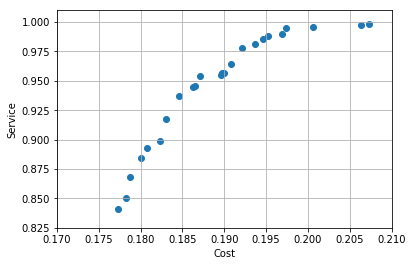

In [58]:
#RESULTING non-dominated front PLOT from 1 realization of the algorithm
#In order to compare the data with ESTECO's benchmark multiply by -1 the second objective function.

plt.scatter(np.array(np.matrix(F.values())[:,0]),-np.array(np.matrix(F.values())[:,1]))
plt.ylim((0.825,1.01))
plt.xlim((0.17,0.21))
plt.xlabel('Cost')
plt.ylabel('Service')
plt.grid()
plt.show()